Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
---> Epoch 0
ave mse 1.957 ===> Total training time: 0.158 seconds.
---> Epoch 1
ave mse 1.806 ===> Total training time: 0.395 seconds.
---> Epoch 2
ave mse 1.705 ===> Total training time: 0.641 seconds.
---> Epoch 3
ave mse 1.625 ===> Total training time: 0.884 seconds.
---> Epoch 4
ave mse 1.557 ===> Total training time: 1.125 seconds.
---> Epoch 5
ave mse 1.497 ===> Total training time: 1.367 seconds.
---> Epoch 6
ave mse 1.442 ===> Total training time: 1.6 seconds.
---> Epoch 7
ave mse 1.391 ===> Total training time: 1.855 seconds.
---> Epoch 8
ave mse 1.344 ===> Total training time: 2.094 seconds.
---> Epoch 9
ave mse 1.3 ===> Total training time: 2.361 seconds.
---> Epoch 10
ave mse 1.258 ===> Total training time: 2.79 seconds.
---> Epoch 11
ave mse 1.219 ===> Total training time: 3.209 seconds.
---> Epoch 12
ave mse 1.181 ===> Total training time: 3.61

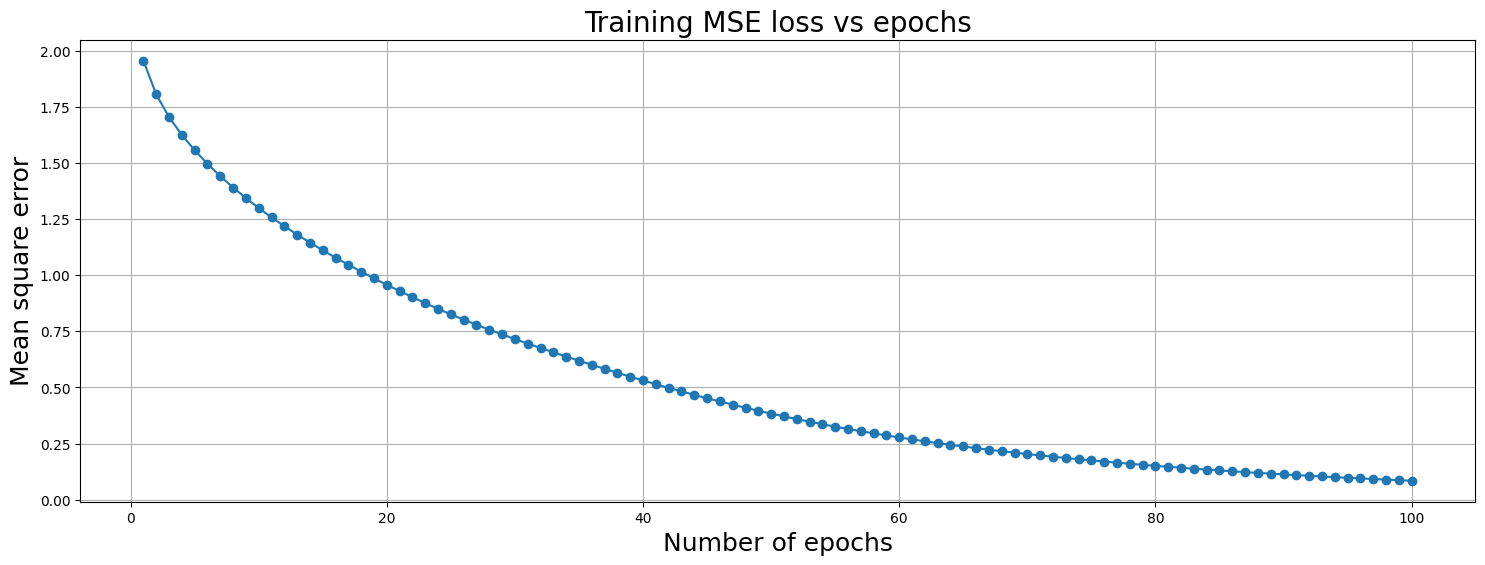

In [3]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load training data from Google Drive
df = pd.read_csv('/content/drive/MyDrive/train.csv')

# Load test data from Google Drive
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

# Column names of the dataset
user_col, name_col, rating_col = 'user_id', 'name', 'stars'

# Filter training data: Keep only users and items with minimum interactions
filtered_df = df.groupby(user_col).filter(lambda x: len(x) >= 5)
filtered_df = filtered_df.groupby(name_col).filter(lambda x: len(x) >= 5)

# Reduce dataset size: Limit to 10,000 rows to save memory
filtered_df = filtered_df.sample(n=10000, random_state=42)
filtered_df = filtered_df[filtered_df[name_col] != 'Apple Store']

# Convert user_id and name to numeric values
user_ids, user_names = pd.factorize(filtered_df[user_col])
name_ids, name_labels = pd.factorize(filtered_df[name_col])
ratings_data = filtered_df[rating_col].values.astype(np.int32)

# Create a CSR matrix for training data
ratings = csr_matrix(
    (ratings_data, (user_ids, name_ids)),
    shape=(len(np.unique(user_ids)), len(np.unique(name_ids)))
).toarray()

# Convert to DataFrame
user_item_matrix = pd.DataFrame(ratings, index=user_names, columns=name_labels)

class MatrixFactorization():
    def __init__(self, ratings, n_factors=100, l_rate=0.01, alpha=0.01, n_iter=100):
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.non_zero_row_ind, self.non_zero_col_ind = ratings.nonzero()
        self.n_interac = len(ratings[np.where(ratings != 0)])
        self.ind_lst = list(range(self.n_interac))
        self.n_factors = n_factors
        self.l_rate = l_rate
        self.alpha = alpha
        self.n_iter = n_iter
        self.mse_lst = []
        self.wait = 10
        self.tol = 1e-3
        self.n_iter_no_change = 10
        self.verbose = True
        self.stop = False

    def initialize(self):
        self.now = time.time()
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)
        self.user_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_items, self.n_factors))
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        self.evaluate_the_model(0)

    def predict(self, u, i):
        return self.global_bias + self.user_biases[u] + self.item_biases[i] + self.user_vecs[u] @ self.item_vecs[i]

    def update_biases_and_vectors(self, error, u, i):
        self.user_biases[u] += self.l_rate * (error - self.alpha * self.user_biases[u])
        self.item_biases[i] += self.l_rate * (error - self.alpha * self.item_biases[i])
        self.user_vecs[u, :] += self.l_rate * (error * self.item_vecs[i, :] - self.alpha * self.user_vecs[u, :])
        self.item_vecs[i, :] += self.l_rate * (error * self.user_vecs[u, :] - self.alpha * self.item_vecs[i, :])

    def evaluate_the_model(self, epoch):
        tot_square_error = 0
        for index in self.ind_lst:
            u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
            pred_rat = self.predict(u, i)
            tot_square_error += (self.ratings[u, i] - pred_rat) ** 2
        mse = tot_square_error / self.n_interac
        self.mse_lst.append(mse)
        if self.verbose:
            print(f"---> Epoch {epoch}")
            temp = np.round(time.time() - self.now, 3)
            print(f"ave mse {np.round(self.mse_lst[-1], 3)} ===> Total training time: {temp} seconds.")

    def early_stopping(self, epoch):
        if (self.mse_lst[-2] - self.mse_lst[-1]) <= self.tol:
            if self.wait == self.n_iter_no_change:
                temp = np.round(time.time() - self.now, 3)
                if self.verbose: print(f"Convergence after {epoch} epochs time took: {temp} seconds.")
                self.stop = True
                self.conv_epoch_num = epoch
            self.wait += 1
        else:
            self.wait = 0

    def fit(self):
        self.initialize()
        for epoch in range(1, self.n_iter):
            np.random.shuffle(self.ind_lst)
            if not self.stop:
                for index in self.ind_lst:
                    u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
                    pred_rat = self.predict(u, i)
                    error = self.ratings[u, i] - pred_rat
                    self.update_biases_and_vectors(error, u, i)
                self.evaluate_the_model(epoch)
                self.early_stopping(epoch)
        self.conv_epoch_num = epoch
        self.plot_the_score()

    def result(self):
        return self.user_vecs, self.item_vecs

    def filled_user_item_matrix(self):
        filled_matrix = np.zeros((self.n_users, self.n_items))
        for u in range(self.n_users):
            for i in range(self.n_items):
                filled_matrix[u, i] = self.predict(u, i)
        return pd.DataFrame(filled_matrix, index=user_names, columns=name_labels)

    def plot_the_score(self):
        plt.figure(figsize=(18, 6))
        plt.plot(range(1, 1 + len(self.mse_lst)), self.mse_lst, marker='o')
        plt.title("Training MSE loss vs epochs", fontsize=20)
        plt.xlabel('Number of epochs', fontsize=18)
        plt.ylabel('Mean square error', fontsize=18)
        plt.grid()
        plt.show()

# 모델 초기화 및 학습
obj = MatrixFactorization(ratings)
obj.fit()

# 채워진 사용자-아이템 매트릭스 반환
filled_user_item_matrix = obj.filled_user_item_matrix()


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
filled_user_item_matrix

,Nando's PERi-PERi,Tango,Jules Thin Crust,Walden's Coffeehouse,Pizza Hut,Imo's Pizza,Walmart Supercenter,XIX Nineteen,Jockamo Upper Crust Pizza,Insomnia Cookies,...,DoubleTree by Hilton Hotel Philadelphia Airport,The Donut + Dog,Sesame Chinese Restaurant,Frank's Pizza,Aman's Indian Bistro,Alfred Angelo Bridal,Dollarama,United Parcel Service,Back Bar,Solar Nails & Spa
Rpqf0uVt6XENIvrbaSciiA,4.132851,3.501870,4.203795,4.222405,2.422299,3.400495,2.580347,3.294695,4.099324,4.289082,...,2.891412,4.171062,2.322646,4.169704,3.316944,4.174401,2.467018,3.743867,3.892776,4.171116
TFw7YRiyl4r2nw3_JFh2Ww,3.223108,2.485885,3.296023,3.319876,1.528565,2.487028,1.662993,2.389821,3.191161,3.381437,...,1.979597,3.260703,1.423169,3.258956,2.409556,3.259416,1.557835,2.835876,2.979960,3.263137
_BcWyKQL16ndpBdggh2kNA,4.197882,3.581985,4.638355,4.301320,2.473445,3.410685,2.624407,3.380207,4.183360,4.355148,...,2.950790,4.225110,2.401043,4.221145,3.368658,4.241179,2.525934,3.805045,3.956167,4.258737
NAtkmn07-dNVA6YMqZCs6Q,4.674609,4.030225,4.742007,4.781086,3.000083,3.925836,3.163372,3.841506,4.637870,4.826393,...,3.429283,4.704098,2.857469,4.704914,3.850724,4.705649,3.000246,4.281919,4.429082,4.708160
UaHRbDqkiCPZPZpymIziHQ,3.519102,2.882801,3.578541,3.591735,1.037128,2.705744,2.058367,2.684041,3.470013,3.665180,...,2.261626,3.553378,1.688608,3.540953,2.684246,3.552434,1.837876,3.113939,3.267453,3.542490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7iFUtwc9hhgGCThohNFwtw,3.214914,2.566723,3.300717,3.298016,1.507275,2.451005,1.667220,2.382189,3.183227,3.373930,...,1.970935,3.252902,1.386037,3.252208,2.401881,3.255211,1.544593,2.828197,2.972011,3.261905
UIeRnK42UJm0_drjF3IpcA,2.713273,2.108241,2.767190,2.822831,0.983714,1.960570,1.425098,1.900461,2.681065,2.859832,...,1.478010,2.747563,0.892847,2.754562,1.896621,2.750269,1.034172,2.320598,2.469907,2.738341
UCUiESd5WPj4c3CkyOIi5Q,4.811791,4.163444,4.882447,4.904344,3.170160,4.123166,3.301372,3.975671,4.776748,4.968152,...,3.567740,4.846412,3.004266,4.854314,3.996213,4.851880,3.146374,4.424302,4.571525,4.852204
cTjFQS2Yyuc27rH0zQ2gyg,5.420088,4.786292,5.496553,5.512691,3.746461,4.694985,3.892670,4.577700,5.391430,5.576304,...,4.183624,5.458003,3.623904,5.461271,4.612190,5.460052,3.761367,5.039361,5.185278,5.462621


In [6]:
user_item_matrix

,Nando's PERi-PERi,Tango,Jules Thin Crust,Walden's Coffeehouse,Pizza Hut,Imo's Pizza,Walmart Supercenter,XIX Nineteen,Jockamo Upper Crust Pizza,Insomnia Cookies,...,DoubleTree by Hilton Hotel Philadelphia Airport,The Donut + Dog,Sesame Chinese Restaurant,Frank's Pizza,Aman's Indian Bistro,Alfred Angelo Bridal,Dollarama,United Parcel Service,Back Bar,Solar Nails & Spa
Rpqf0uVt6XENIvrbaSciiA,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TFw7YRiyl4r2nw3_JFh2Ww,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
_BcWyKQL16ndpBdggh2kNA,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NAtkmn07-dNVA6YMqZCs6Q,0,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UaHRbDqkiCPZPZpymIziHQ,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7iFUtwc9hhgGCThohNFwtw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UIeRnK42UJm0_drjF3IpcA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
UCUiESd5WPj4c3CkyOIi5Q,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cTjFQS2Yyuc27rH0zQ2gyg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# 학습된 사용자와 아이템 벡터 가져오기
user_vecs, item_vecs = obj.result()

# 테스트 데이터 준비
test_user_ids, _ = pd.factorize(test_df[user_col])
test_item_ids, _ = pd.factorize(test_df[name_col])
test_ratings = pd.to_numeric(test_df[rating_col], errors='coerce').fillna(0).values

# 테스트 세트에 대한 예측 계산
predictions = [
    np.clip(obj.predict(test_user_ids[i], test_item_ids[i]), 1, 5)
    if (test_user_ids[i] < len(user_vecs) and test_item_ids[i] < len(item_vecs))
    else np.nan
    for i in range(len(test_user_ids))
]

# 테스트 세트에 대한 예측 평가
test_df['predicted_rating'] = predictions
mse = ((pd.to_numeric(test_df[rating_col], errors='coerce') - test_df['predicted_rating']) ** 2).mean()
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse}")

# 랜덤 사용자 선택 후 상위 3개 추천 항목 출력
random_user = np.random.choice(test_user_ids)
item_scores = [(i, np.clip(obj.predict(random_user, i), 1, 5)) for i in range(len(item_vecs))]
not_sorted_item_scores = item_scores
item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)

k = 5
recommendation_items = []
print(f"\nTop {k} recommendations for user {random_user}:")
for idx, score in item_scores[:k]:
    recommendation_items.append(item_scores[idx][0])
    print(f"Restaurant: {name_labels[idx]}, Predicted Rating: {score}")

Test RMSE: 1.7032865458228885

Top 5 recommendations for user 5304:
Restaurant: Nothing Bundt Cakes, Predicted Rating: 5.0
Restaurant: Fritz's Bakery, Predicted Rating: 5.0
Restaurant: Angelo's Pizzeria, Predicted Rating: 5.0
Restaurant: Mediterranean Grill, Predicted Rating: 5.0
Restaurant: La Estrella Bakery, Predicted Rating: 5.0


In [8]:
# evaluation
print('test_df with predictions:\n', test_df)
print('\n')

random_user_name = test_df['user_id'][random_user]
print('random user index:', random_user)
print('random user name:', random_user_name)
print('item_scores:', not_sorted_item_scores)
print('items that user rated:\n', test_df[test_df['user_id'] == random_user_name])
print('recommendated items: ', recommendation_items)
print('\n')

# predicted ratings의 평가
# mse and rmse
print('mse: ', mse)
print('rmse: ', rmse)
print('\n')

# 랜덤한 한 유저에 대한 rank 평가
# precision@k
user_rated_items = test_df[test_df['user_id'] == random_user_name]['business_id']
true_positive = sum((item in user_rated_items for item in recommendation_items))
precision = true_positive / k
print(f'precision@{k} for user {random_user_name}: {precision}')

# recall@k
recall = true_positive / len(user_rated_items)
print(f'recall@{k} for user {random_user_name}: {recall}')

test_df with predictions:
       Unnamed: 0               user_id  business_id stars              name  \
0              0     Rusha Chakraborty            0     5   Beyond Flavours   
1              1  Anusha Tirumalaneedi            1     5   Beyond Flavours   
2              2       Ashok Shekhawat            2     5   Beyond Flavours   
3              3        Swapnil Sarkar            3     5   Beyond Flavours   
4              4                Dileep            4     5   Beyond Flavours   
...          ...                   ...          ...   ...               ...   
9995        9995      Abhishek Mahajan         9995     3  Chinese Pavilion   
9996        9996        Sharad Agrawal         9996   4.5  Chinese Pavilion   
9997        9997             Ramandeep         9997   1.5  Chinese Pavilion   
9998        9998       Nayana Shanbhag         9998     4  Chinese Pavilion   
9999        9999      Bhargava Krishna         9999   3.5  Chinese Pavilion   

      predicted_rating  

In [9]:
# 모든 유저에 대한 rank 평가
# Mean Average Precision@k
test_df = test_df.drop_duplicates(subset=['user_id'])  # make user ids unique
test_user_ids = test_df['user_id']
average_precision_sum = 0

for test_user_id in test_user_ids:
  test_user_indices = test_df[test_df['user_id'] == test_user_id].index
  if len(test_user_indices) <= 0: continue
  test_user_index = test_df[test_df['user_id'] == test_user_id].index[0]
  user_rated_items = test_df[test_df['user_id'] == test_user_id]['business_id']

  if test_user_index >= len(item_vecs): continue
  item_scores = [(i, obj.predict(test_user_index, i)) for i in range(len(item_vecs))]
  item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)

  precision_sum = 0

  # calculate precision in range 1 to k
  for k_i in range(1,  k + 1):
      recommendation_items = []
      for idx, score in item_scores[:k_i]:
          recommendation_items.append(item_scores[idx][0])

      # calculate Average Precision
      # if item is rated by user, relevance is 1 and otherwise 0
      # 0 make Average Precision to 0 so, calculate only when relevance is 1
      if recommendation_items[k_i - 1] in user_rated_items:
        true_positive_of_i = sum((item in user_rated_items for item in recommendation_items[:k_i]))
        precision_of_i = true_positive_of_i / k_i
        precision_sum += precision_of_i

  average_precision = precision_sum / len(user_rated_items)
  average_precision_sum += average_precision

mean_average_precision = average_precision_sum / len(test_user_ids)
print(f'mean average precision@{k}: {mean_average_precision}')

mean average precision@5: 0.0005796517613356609
